In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('601088', start='2021-08-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
140,2021-08-02,14.32,14.70,14.76,14.16,354968.0,601088
141,2021-08-03,14.65,14.72,14.82,14.46,310872.0,601088
142,2021-08-04,14.66,14.81,14.87,14.57,233550.0,601088
143,2021-08-05,14.74,14.89,14.99,14.72,300208.0,601088
144,2021-08-06,14.86,14.98,14.99,14.77,296511.0,601088
...,...,...,...,...,...,...,...
238,2021-12-27,20.03,20.26,20.73,19.88,284122.0,601088
239,2021-12-28,20.54,19.74,20.56,19.43,340842.0,601088
240,2021-12-29,19.79,19.74,20.11,19.64,198245.0,601088
241,2021-12-30,19.57,19.40,19.88,19.37,220861.0,601088


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
140,14.32,14.70
141,14.65,14.72
142,14.66,14.81
143,14.74,14.89
144,14.86,14.98
...,...,...
238,20.03,20.26
239,20.54,19.74
240,19.79,19.74
241,19.57,19.40


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.        , 0.        ],
       [0.04495913, 0.00296296],
       [0.04632153, 0.0162963 ],
       [0.05722071, 0.02814815],
       [0.07356948, 0.04148148],
       [0.08991826, 0.05037037],
       [0.09264305, 0.06666667],
       [0.12125341, 0.09925926],
       [0.14168937, 0.0962963 ],
       [0.13760218, 0.10666667],
       [0.16076294, 0.10222222],
       [0.12942779, 0.08      ],
       [0.1253406 , 0.04740741],
       [0.09128065, 0.02222222],
       [0.0640327 , 0.00296296],
       [0.08174387, 0.06518519],
       [0.12942779, 0.08296296],
       [0.1280654 , 0.11555556],
       [0.16621253, 0.14814815],
       [0.15122616, 0.1362963 ],
       [0.19618529, 0.25037037],
       [0.26294278, 0.40888889],
       [0.44822888, 0.33925926],
       [0.36376022, 0.42518519],
       [0.41280654, 0.40444444],
       [0.46321526, 0.52296296],
       [0.5640327 , 0.59851852],
       [0.56811989, 0.67703704],
       [0.70027248, 1.        ],
       [0.90599455, 0.76444444],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(77, 2)
(26, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(57, 14, 2)
(57, 1)
(6, 14, 2)
(6, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.3050 - val_loss: 0.1592
Epoch 2/10
1/1 [==============================] - 0s 78ms/step - loss: 0.2515 - val_loss: 0.1252
Epoch 3/10
1/1 [==============================] - 0s 79ms/step - loss: 0.2076 - val_loss: 0.0954
Epoch 4/10
1/1 [==============================] - 0s 79ms/step - loss: 0.1679 - val_loss: 0.0709
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.1263 - val_loss: 0.0542
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 0.0943 - val_loss: 0.0497
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.0757 - val_loss: 0.0623
Epoch 8/10
1/1 [==============================] - 0s 106ms/step - loss: 0.0751 - val_loss: 0.0887
Epoch 9/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0943 - val_loss: 0.1063
Epoch 10/10
1/1 [==============================] - 0s 85ms/step - loss: 0.1027 - val_loss: 0.1063


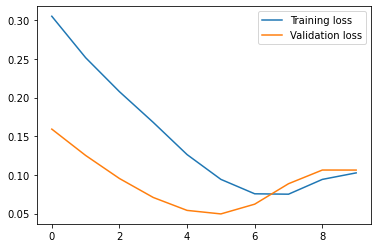

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 1s 1s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48782/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

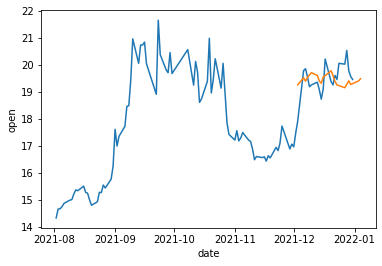

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [15]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result.to_csv("601088_ZGSH.csv")

In [15]:
df.to_csv("601088_ZGSH.csv")